# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math


In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Общая информация о данных

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',sep='\t')

### Описание данных

**total_images** — число фотографий квартиры в объявлении

**last_price** — цена на момент снятия с публикации

**total_area** — общая площадь квартиры в квадратных метрах (м²)

**first_day_exposition** — дата публикации

**rooms** — число комнат

**ceiling_height** — высота потолков (м)

**floors_total** — всего этажей в доме

**living_area** — жилая площадь в квадратных метрах (м²)

**floor** — этаж

**is_apartment** — апартаменты (булев тип)

**studio** — квартира-студия (булев тип)

**open_plan** — свободная планировка (булев тип)

**kitchen_area** — площадь кухни в квадратных метрах (м²)

**balcony** — число балконов

**locality_name** — название населённого пункта

**airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)

**cityCenters_nearest** — расстояние до центра города (м)

**parks_around3000** — число парков в радиусе 3 км

**parks_nearest** — расстояние до ближайшего парка (м)

**ponds_around3000** — число водоёмов в радиусе 3 км

**ponds_nearest** — расстояние до ближайшего водоёма (м)

**days_exposition** — сколько дней было размещено объявление (от публикации до снятия)





План исследования:
1. Определяем целевые переменные

Целевой переменной исследования будет переменная last_price - последняя цена на момент снятия с публикации. Влияние параметров на эту переменную мы и будем исследовать.

Также для нашего исследования будет полезна метрика цены за квадратный метр.

2. Исследование сырых данных, описание проблем данных и предобработка

На этапе обработки опишем и обработаем проблемы, связанные с пропусками значений и исправим их, где это будет возможно

3. Исследовательский анализ данных

Проведем исследование данных в виде сводных таблиц и графиков, зафиксируем промежуточные выводы

4. Подведение общих итогов исследования, выводы

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Нам предстоит обработать пропуски в столбцах:
    
    ceiling_height
    floors_total  
    living_area 
    is_apartment 
    kitchen_area
    balcony
    locality_name
    airports_nearest
    cityCenters_nearest
    parks_around3000
    parks_nearest
    ponds_around3000
    ponds_nearest
    days_exposition
Также нам предстоит поменять тип данных в столбцах:
    
    first_day_exposition
    floors_total
    is_apartment
    balcony
    parks_around3000
    ponds_around3000
    days_exposition


In [6]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


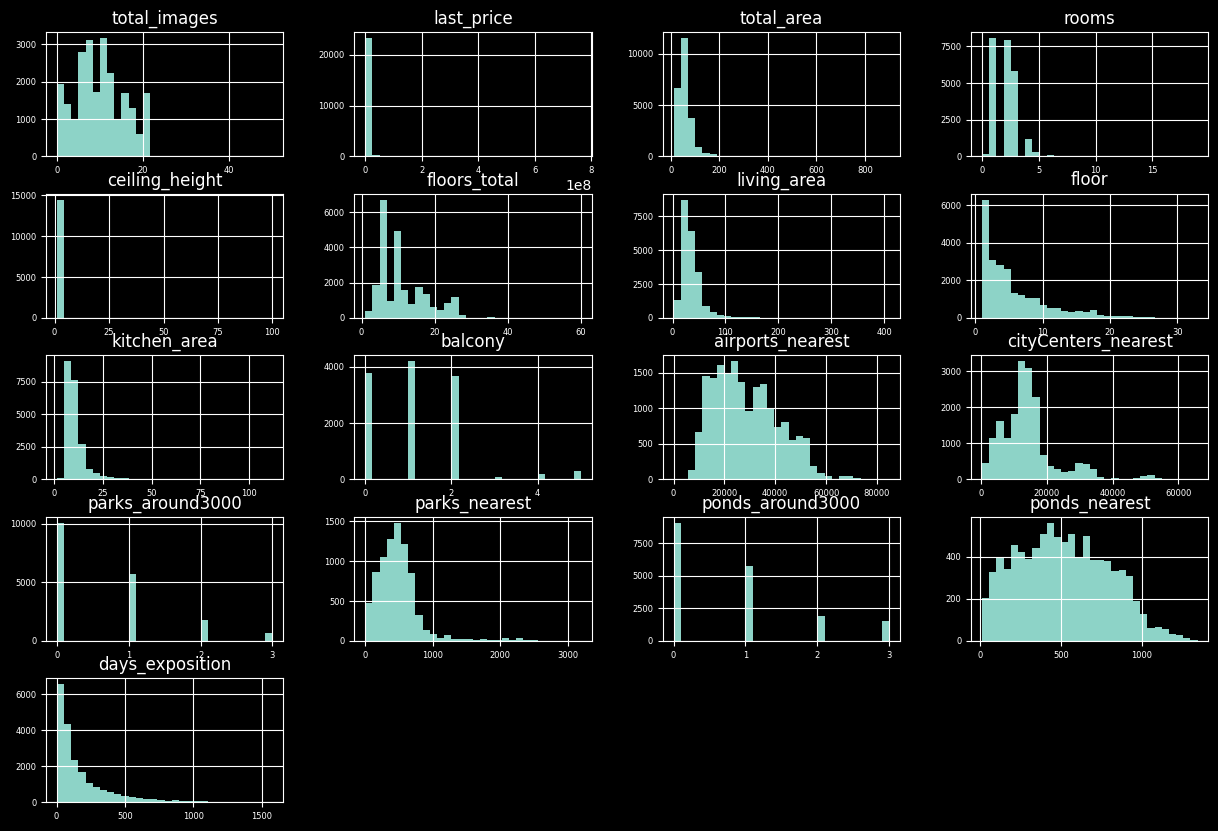

In [7]:
df.hist(bins=30,figsize=(15,10),xlabelsize=6,ylabelsize=6);

Первый взгляд на гистограммы показывает, что нам предстоит обработать выбросы в столбцах:
    
    last_price
    rooms
    ceiling_height

Более детальное рассмотрение каждого параметра поможет понять и другие проблемы в данных.

### Исследование сырых данных, описание проблем и предобработка

Пойдем по порядку столбцов. С параметром total_images - количество фотографий - проблем не обнаружено, тип данных верный, пропусков нет.

Что касается целевой переменной, по гистограмме заметны значительные выбросы:

<Axes: >

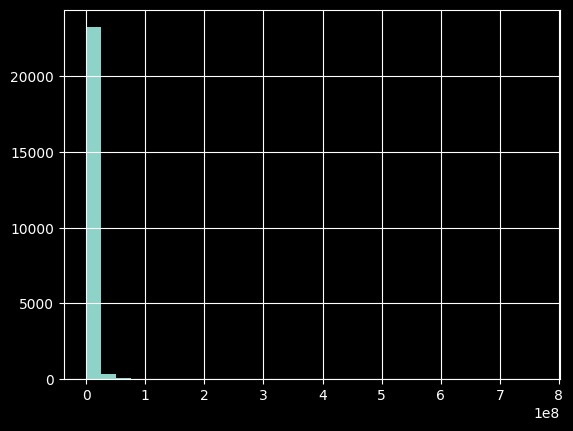

In [8]:
df.last_price.hist(bins=30)

In [9]:
df.last_price.describe([0.05,0.1,0.25,0.5,0.75,0.9,0.95])

count       23699.00
mean      6541548.77
std      10887013.27
min         12190.00
5%        1870000.00
10%       2500000.00
25%       3400000.00
50%       4650000.00
75%       6800000.00
90%      10914231.20
95%      15300000.00
max     763000000.00
Name: last_price, dtype: float64

Медиана - около 6.5 млн рублей, 75 процентиль - 6.8 млн. Для определения выбросов также поможет boxplot

<Axes: >

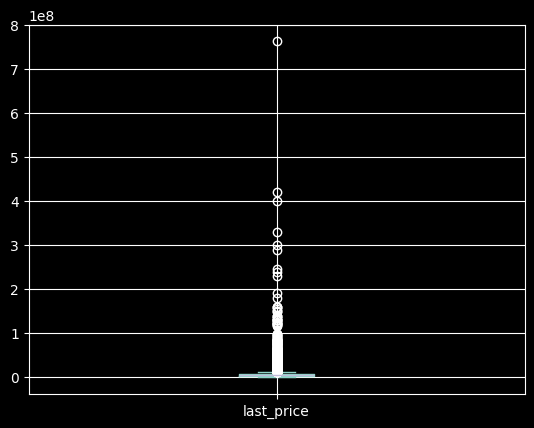

In [10]:
df.last_price.plot(kind='box',grid=True)

Для начала, отбросим самый "выбивающиеся" выбросы - те, что указаны выше 50 млн.


In [11]:
df.query('last_price > 50000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
155,8,96000000.00,317.00,2017-07-07T00:00:00,4,3.50,3.00,183.00,3,NaN,...,NaN,1.00,Санкт-Петербург,22673.00,1771.00,2.00,508.00,3.00,366.00,62.00
464,15,66571000.00,280.30,2015-06-11T00:00:00,6,5.20,8.00,159.50,7,NaN,...,21.10,0.00,Санкт-Петербург,26316.00,6655.00,3.00,187.00,1.00,616.00,578.00
492,18,95000000.00,216.00,2017-12-05T00:00:00,4,3.00,5.00,86.00,4,NaN,...,77.00,NaN,Санкт-Петербург,21740.00,436.00,2.00,138.00,3.00,620.00,14.00
509,5,90000000.00,225.00,2016-06-26T00:00:00,6,NaN,4.00,134.00,2,NaN,...,19.50,2.00,Санкт-Петербург,32864.00,5720.00,0.00,NaN,2.00,519.00,416.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22709,20,59000000.00,127.50,2016-12-21T00:00:00,4,3.00,12.00,85.00,8,NaN,...,13.00,1.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,635.00
22804,4,81960000.00,205.00,2017-09-29T00:00:00,4,3.20,9.00,108.00,3,NaN,...,10.00,NaN,Санкт-Петербург,21946.00,2242.00,1.00,679.00,1.00,227.00,169.00
22831,18,289238400.00,187.50,2019-03-19T00:00:00,2,3.37,6.00,63.70,6,NaN,...,30.20,NaN,Санкт-Петербург,22494.00,1073.00,3.00,386.00,3.00,188.00,NaN
22907,9,65000000.00,228.00,2016-06-02T00:00:00,4,NaN,5.00,200.00,2,NaN,...,NaN,NaN,Санкт-Петербург,22783.00,1295.00,3.00,619.00,3.00,269.00,NaN


Таких записей - 101 штука, меньше 0.5% всей выборки. Их можно отбросить

In [12]:
df = df.drop(df.query('last_price > 50000000').index)

<Axes: >

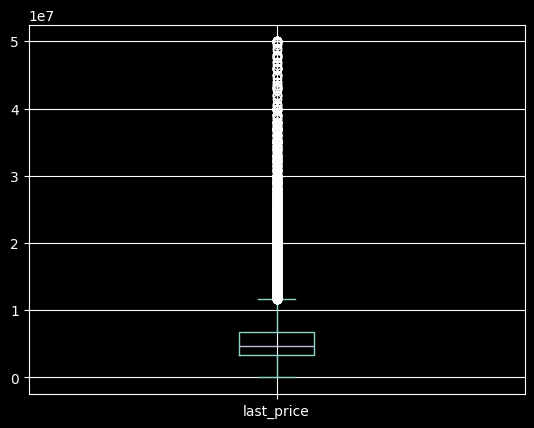

In [13]:
df.last_price.plot(kind='box',grid=True)

Теперь боксплот выглядит визуально более показательным. Также предлагаю посмотреть на низ гистограммы, дешевые квартиры:

In [14]:
df.query('last_price < 500000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.00,42.00,2017-07-31T00:00:00,2,NaN,1.00,23.00,1,NaN,...,5.80,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.00
6859,6,490000.00,40.00,2017-12-11T00:00:00,1,NaN,5.00,NaN,3,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.00
8793,7,12190.00,109.00,2019-03-20T00:00:00,2,2.75,25.00,32.00,25,NaN,...,40.50,NaN,Санкт-Петербург,36421.00,9176.00,1.00,805.00,0.00,NaN,8.00
9581,7,450000.00,43.40,2018-08-31T00:00:00,2,NaN,5.00,30.30,3,NaN,...,5.50,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.00
10782,3,490000.00,29.10,2016-05-05T00:00:00,1,2.50,5.00,17.00,5,NaN,...,5.50,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.00
14911,5,430000.00,54.00,2018-06-26T00:00:00,2,NaN,3.00,NaN,3,NaN,...,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.00
16032,8,480000.00,32.00,2019-01-06T00:00:00,1,NaN,2.00,16.00,1,NaN,...,NaN,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.00
16219,14,450000.00,38.50,2018-07-11T00:00:00,2,2.65,2.00,NaN,1,NaN,...,NaN,NaN,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.00
16274,18,440000.00,40.00,2018-07-10T00:00:00,1,NaN,5.00,NaN,1,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.00
17456,7,430000.00,30.40,2019-04-22T00:00:00,1,NaN,2.00,16.00,1,NaN,...,6.00,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Минимальное значение - 12190 рублей за квартиру - кажется нереалистичным. Скорее всего в данные попало предложение об аренде. Его также удалим из данных.

In [15]:
df = df.drop(index=8793)

<Axes: >

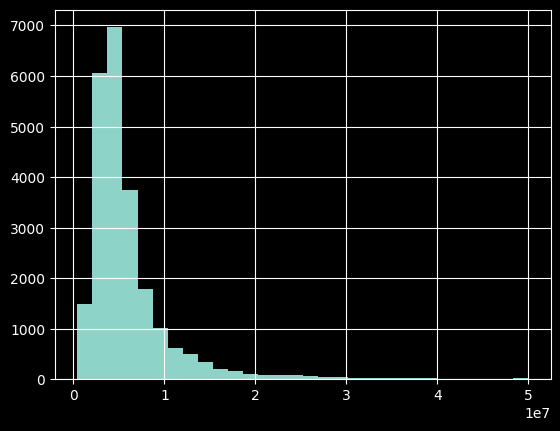

In [16]:
df.last_price.hist(bins=30)

Данные о дате публикации (first_day_exposition). Пропусков нет, но формат данных object - исправим это

In [17]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

<Axes: >

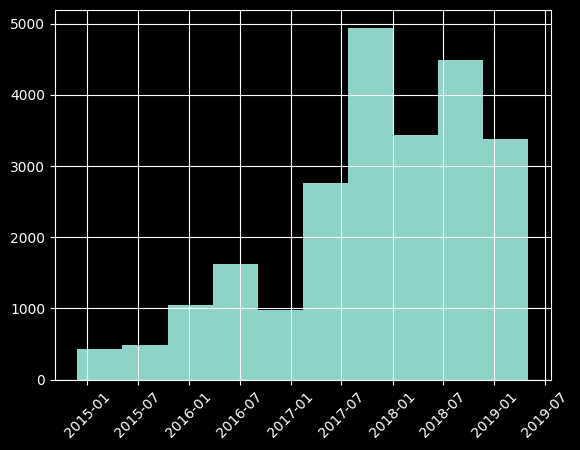

In [18]:
df['first_day_exposition'].hist(xrot=45)

Аномалий в дате публикаций не видно, можно двигаться дальше

Высота потолков (ceiling_height). С форматом все в порядке, но есть большое количество пропусков:

In [19]:
df['ceiling_height'].isna().sum()

9152

9192 - это большое количество пропусков, и их удаление приведет к искажению выборки. Спрогнозировать их не представляется возможным. Пока оставим их как есть и посмотрим на выбросы:

<Axes: >

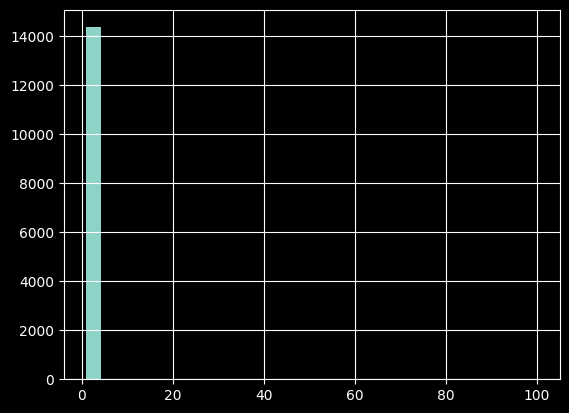

In [20]:
df['ceiling_height'].hist(bins=30)

Кроме собственно пропусков, есть существенные выбросы. Сложно представить жилье с потолками выше 15 метров. Выведем такие выбросы:

In [21]:
df.query('ceiling_height > 20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.00,55.20,2018-07-12,2,25.00,5.00,32.00,2,False,...,NaN,2.00,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.00
3148,14,2900000.00,75.00,2018-11-12,3,32.00,3.00,53.00,2,NaN,...,8.00,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.00,45.00,2018-02-01,2,25.00,9.00,30.00,2,NaN,...,7.00,1.00,Санкт-Петербург,12016.00,13256.00,1.00,658.00,1.00,331.00,181.00
4876,7,3000000.00,25.00,2017-09-27,0,27.00,25.00,17.00,17,NaN,...,NaN,2.00,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.00
5076,0,3850000.00,30.50,2018-10-03,1,24.00,5.00,19.50,1,True,...,5.50,NaN,Санкт-Петербург,29686.00,8389.00,3.00,397.00,1.00,578.00,7.00
5246,0,2500000.00,54.00,2017-10-13,2,27.00,5.00,30.00,3,NaN,...,9.00,2.00,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.00
5669,4,4400000.00,50.00,2017-08-08,2,26.00,9.00,21.30,3,NaN,...,7.00,2.00,Санкт-Петербург,28981.00,10912.00,1.00,305.00,0.00,NaN,267.00
5807,17,8150000.00,80.00,2019-01-09,2,27.00,36.00,41.00,13,NaN,...,12.00,5.00,Санкт-Петербург,18732.00,20444.00,0.00,NaN,3.00,80.00,38.00
6246,6,3300000.00,44.40,2019-03-25,2,25.00,5.00,31.30,5,NaN,...,5.70,NaN,Кронштадт,68923.00,50649.00,1.00,417.00,2.00,73.00,NaN
9379,5,3950000.00,42.00,2017-03-26,3,25.00,5.00,30.00,2,NaN,...,5.20,NaN,Санкт-Петербург,11647.00,13581.00,0.00,NaN,0.00,NaN,NaN


Большинство значений в этом срезе находятся на промежутке 20 - 40, и логично предположить, что здесь просто смещен разделитель.

Единственный "реальный" выброс здесь один - строка 22869. Стометровый потолок представить сложно, а запись можно спокойно удалить из датасета

In [22]:
df.loc[df['ceiling_height'] > 20,'ceiling_height'] = df.loc[df['ceiling_height'] > 15,'ceiling_height'].apply(lambda x:x*0.1)
df.drop(index=22869,inplace=True)

<Axes: >

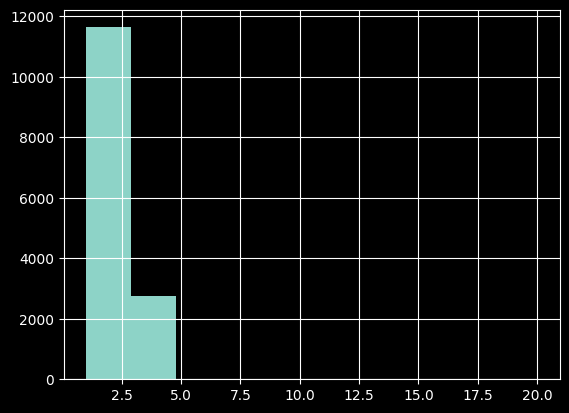

In [23]:
df['ceiling_height'].hist()

Посмотрим на оставшиеся выбросы, с размером потолков выше 6 метров

In [24]:
df[df['ceiling_height'] > 6]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000.00,30.00,2018-03-16,1,8.00,5.00,15.30,2,False,...,7.30,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.00
5863,20,5650000.00,45.00,2018-08-15,1,8.30,16.00,19.30,14,NaN,...,8.30,1.00,Санкт-Петербург,13069.00,10763.00,0.00,NaN,1.00,613.00,14.00
15061,19,5600000.00,56.40,2018-05-11,2,14.00,14.00,32.40,5,NaN,...,9.10,2.00,Санкт-Петербург,14814.00,13610.00,0.00,NaN,0.00,NaN,315.00
15743,14,5600000.00,67.00,2016-11-11,3,8.00,16.00,41.00,1,NaN,...,8.00,NaN,Санкт-Петербург,32691.00,11035.00,1.00,723.00,0.00,NaN,474.00
17442,0,5350000.00,54.00,2015-06-16,2,8.00,5.00,29.00,2,NaN,...,NaN,1.00,Красное Село,24638.00,28062.00,0.00,NaN,0.00,NaN,469.00
17496,15,6700000.00,92.90,2019-02-19,3,20.00,17.00,53.20,14,NaN,...,12.00,5.00,Санкт-Петербург,16295.00,15092.00,1.00,967.00,0.00,NaN,NaN
22309,20,5300000.00,45.00,2017-09-30,1,10.30,16.00,15.50,15,NaN,...,NaN,NaN,Санкт-Петербург,36353.00,11936.00,2.00,440.00,2.00,450.00,136.00


Таких записей всего 6, их тоже можно удалить

<Axes: >

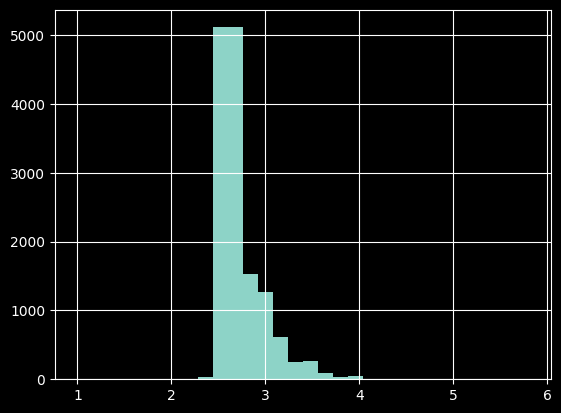

In [25]:
df.drop(df[df['ceiling_height'] > 6].index,inplace=True)
df['ceiling_height'].hist(bins=30)

Большинство потолков больше 2.5 метров, доходит до 4х - кажется, данные не оторваны от реальности.

Далее рассмотрим столбцы floors_total и floors. Помним, что нам важно, чтобы floors было всегда меньше floors_total

In [26]:
df['floors_total'].isna().sum()

86

In [27]:
df['floor'].isna().sum()

0

In [28]:
df[df['floors_total'] < df['floor']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Получается, что нам не хватает только небольшого количества значений в столбце floors_total. Есть два варианта - заполнить их значением этажа квартиры, которая указана, или удалить совсем, тк количество таких квартир небольшое. Выберем первый вариант, тк он меньше исказит данные во всем датафрейме

In [29]:
df = df.drop(df[df['floors_total'].isna()].index)

In [30]:
df['floors_total'].isna().sum()

0

Пропусков не осталось. Теперь можно заменить тип данных на int

In [31]:
df['floors_total'] = df['floors_total'].astype('int')

Посмотрим на гистограммы:

array([[<Axes: title={'center': 'floors_total'}>,
        <Axes: title={'center': 'floor'}>]], dtype=object)

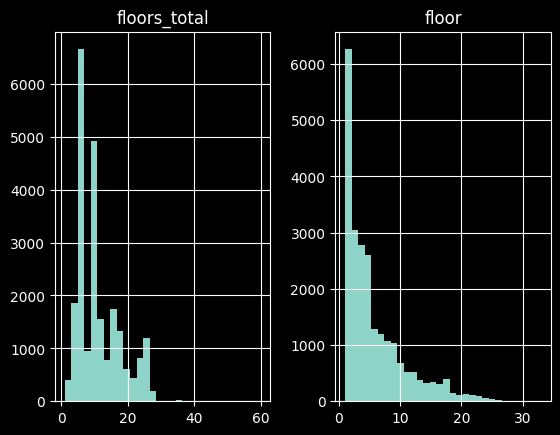

In [32]:
df[['floors_total','floor']].hist(bins=30)

Распределение выглядит логичным, нулевых значений нет. Следующий параметр: rooms (количество комнат). Сначала посмотрим на гистограмму

<Axes: >

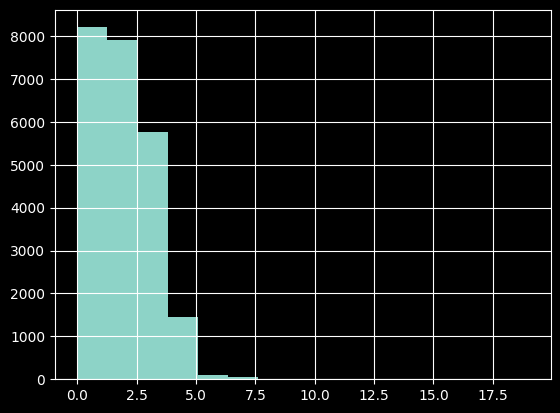

In [33]:
df.rooms.hist(bins=15)

Обратим внимание на квартиры где:
- количество комнат больше или равно 8
- количество комнат равно 0

In [34]:
df[df['rooms'] > 7]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000.00,183.70,2018-07-01,11,3.40,7,138.80,7,NaN,...,13.30,NaN,Санкт-Петербург,23606.00,3148.00,0.00,NaN,0.00,NaN,NaN
813,7,16500000.00,229.00,2016-02-25,8,NaN,6,160.00,5,NaN,...,25.00,NaN,Санкт-Петербург,23968.00,4536.00,1.00,243.00,0.00,NaN,806.00
866,5,25000000.00,363.00,2017-12-23,14,3.16,5,222.00,4,NaN,...,16.60,NaN,Санкт-Петербург,38076.00,7950.00,0.00,NaN,2.00,435.00,418.00
4149,6,23000000.00,272.60,2018-01-11,10,3.14,7,145.90,7,NaN,...,18.80,1.00,Санкт-Петербург,10726.00,12169.00,1.00,191.00,1.00,531.00,NaN
4435,13,22190000.00,191.20,2017-12-05,8,2.90,6,115.80,1,NaN,...,5.00,NaN,Санкт-Петербург,21589.00,1152.00,1.00,587.00,2.00,155.00,115.00
8758,5,16100000.00,150.00,2018-07-10,8,2.92,5,107.00,1,NaN,...,7.20,NaN,Санкт-Петербург,26080.00,4782.00,2.00,473.00,0.00,NaN,NaN
8822,14,49968900.00,398.00,2017-07-12,9,3.00,2,160.10,1,False,...,41.00,NaN,Санкт-Петербург,17720.00,16722.00,3.00,471.00,2.00,440.00,471.00
8860,12,17000000.00,235.00,2018-07-14,9,3.00,6,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,24466.00,5034.00,1.00,346.00,0.00,NaN,90.00
9550,10,23500000.00,313.00,2017-02-13,9,3.20,6,179.20,5,NaN,...,13.20,NaN,Санкт-Петербург,38435.00,10138.00,1.00,146.00,0.00,NaN,NaN
9688,8,33000000.00,194.10,2017-02-07,11,3.43,5,129.00,2,NaN,...,11.90,NaN,Санкт-Петербург,21469.00,1015.00,1.00,686.00,2.00,66.00,813.00


С одной стороны, валидность этих данных подтверждается тем, что такие квартиры имеют большую площадь и высокую цену. Но лучше все же удостовериться в реалистичности существования таких квартир: в частности, посмотреть среднее количество квадратных метров на комнату и сравнить это значение с остальной выборкой.

In [35]:
df['avg_room_area'] = df['total_area'] / df['rooms']
df[df['rooms'] > 7]['avg_room_area'].describe()

count   25.00
mean    27.60
std      7.75
min     16.70
25%     21.61
50%     27.77
75%     30.62
max     44.22
Name: avg_room_area, dtype: float64

Минимальное значение средней площади комнаты - 16.7 - не кажется чем-то странным, поэтому все эти строки оставляем. Что касается кейса, где количество комнат = 0:

In [36]:
df.drop(columns='avg_room_area',inplace=True)

In [37]:
df[df['rooms'] == 0]['total_area'].describe()

count   193.00
mean     27.55
std       8.43
min      15.50
25%      24.05
50%      26.05
75%      28.30
max      98.40
Name: total_area, dtype: float64

Большинство таких квартир имеют небольшую площадь - можно предположить, что продавцы указали вместо однокомнатной квартиры указали "нулекомнатную". Заменим значение количества комнат на 1

In [38]:
df.loc[df.rooms == 0, 'rooms'] = 1

In [39]:
df[df['rooms'] == 0].rooms.count()

0

Далее рассмотрим параметр studio подробнее.

In [40]:
df.studio.value_counts()

studio
False    23327
True       146
Name: count, dtype: int64

In [41]:
df.studio.isna().sum()

0

Без пропусков в значениях, всего 150 студий. Студия - это однокомнатная квартира, поэтому посмотрим, есть ли в студиях варианты, где количество комнат больше 1

In [42]:
df.query('studio == True and rooms != 1')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Таких вариантов нет, можно двигаться дальше. Рассмотрим параметр living_area - жилая площадь

In [43]:
df.living_area.isna().sum()

1854

In [44]:
df.living_area.describe()

count   21619.00
mean       33.87
std        19.80
min         2.00
25%        18.60
50%        30.00
75%        42.00
max       332.00
Name: living_area, dtype: float64

Всего 1902 пропущенных значений - это примерно 8% выборки. Это не так много, но и не мало, чтобы можно было полностью удалить пропуски из выборки. Есть два варианта: можно удалить пропущенные значения полностью, либо заменить их каким-либо значением. Например, по существующим данным можно посчитать процент жилой площади от общей, сгруппировать данные по количеству комнат и заполнить пропуски значением общей площади помноженным на медианное значение процента жилой площади. Используем второй подход:

In [45]:
df['living_area_percent'] = df['living_area'] / df['total_area']
for i in df['rooms'].unique():
    df.loc[(df['rooms'] == i) & (df['living_area'].isna()),'living_area'] = df.groupby('rooms')['living_area_percent'].agg('median').loc[i] * df['total_area']
df.drop(columns='living_area_percent',inplace=True)

In [46]:
df.living_area.isna().sum()

0

Посмотрим на гистограмму жилой площади. Есть ли варианты, когда жилая площадь больше, чем площадь всей квартиры?

<Axes: >

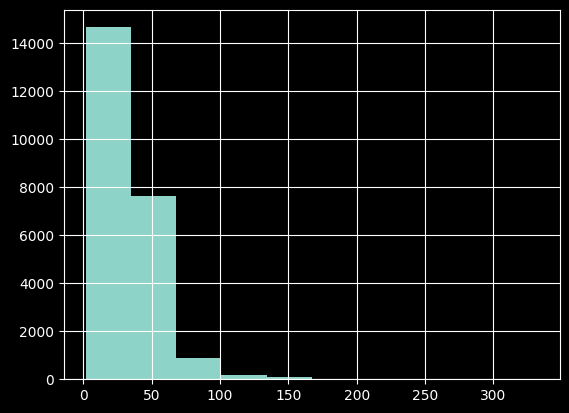

In [47]:
df.living_area.hist()

In [48]:
df.query('living_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Таких случаев нет. Можно двигаться дальше. Далее - параметр is_apartament. Тип параметра в таблице - object, но параметр принимает только занчения False и True, то его нужно перевести в тип bool. Здесь очень много отсутствующих значений:

In [49]:
df.is_apartment.isna().sum()


20716

In [50]:
df['is_apartment'] = df['is_apartment'].astype(bool)
df.is_apartment.dtypes

dtype('bool')

К сожалению, по косвенным признакам сказать, является ли квартира апартаментом или не является, нельзя, поэтому оставим пропуски как есть. Далее - площадь кухни, kitchen_area. Исследуем параметр по аналогии с living area: узнаем количество пропусков, можно ли их заполнить или удалить, есть ли аномальные и нереалистичные случаи.

<Axes: >

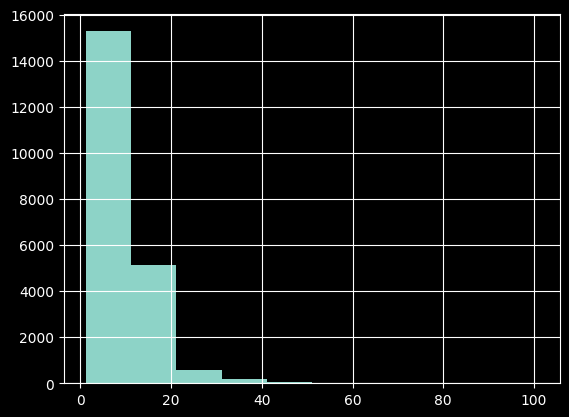

In [51]:
df.kitchen_area.hist()

In [52]:
df.kitchen_area.isna().sum()

2211

Заполним пропуски по аналогиии с тем, как мы заполняли living_area

In [53]:
df['kitchen_area_percent'] = df['kitchen_area'] / df['total_area']
for i in df['rooms'].unique():
    df.loc[(df['rooms'] == i) & (df['kitchen_area'].isna()),'kitchen_area'] = df.groupby('rooms')['kitchen_area_percent'].agg('median').loc[i] * df['total_area']
df.drop(columns='kitchen_area_percent',inplace=True)

In [54]:
df.query('kitchen_area > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [55]:
df.kitchen_area.isna().sum()

0

Проверили, пропусков нет, можно двигаться дальше.

Далее рассмотрим параметр balcony.

In [56]:
df.balcony.describe()

count   12063.00
mean        1.16
std         1.07
min         0.00
25%         0.00
50%         1.00
75%         2.00
max         5.00
Name: balcony, dtype: float64

<Axes: >

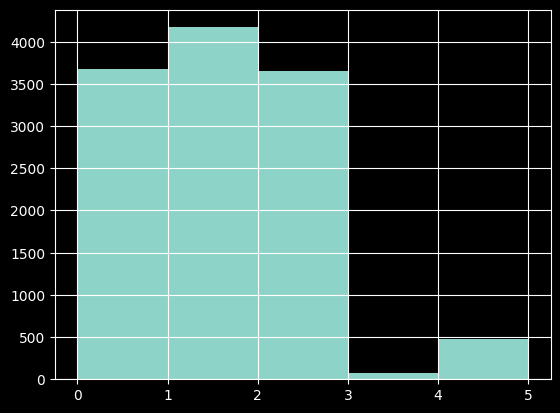

In [57]:
df.balcony.hist(bins=5)

In [58]:
df.balcony.isna().mean()

0.48609040173816725

Примерно половина значений - пропущена. Здесь возможны два варианта - либо балкона действительно нет, либо их забыли указать. В первом случае можно заменить пропуски на 0, во втором - придется оставить как есть. Предположу первый вариант, ориентируясь на распределение гистограммы - кажется, отсутствие балконов более типично для российский квартир, чем его наличие, а по гистограмме видно что наличие одного балкона - это самая частая ситуация.

In [59]:
df.balcony = df.balcony.fillna(0).astype('int')

dtype('int64')

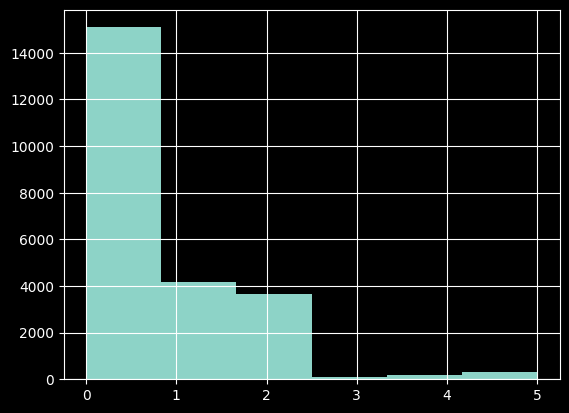

In [60]:
df.balcony.hist(bins=6)
df.balcony.dtypes

Немного странно, что на гистограмме квартир с количеством балконов 4 и 5 больше, чем 3. Особенно странно, когда такое количество балконов находится в относительно небольших квартирах:

In [61]:
df.query('balcony in [4,5] and total_area < 60')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
250,13,3200000.00,51.70,2019-01-22,2,2.65,16,29.20,5,True,...,7.70,4,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,21.00
654,6,2750000.00,36.00,2017-04-18,1,NaN,5,20.50,5,True,...,7.80,4,Кронштадт,69785.00,51511.00,2.00,52.00,3.00,313.00,381.00
1030,11,7985250.00,57.50,2018-08-21,2,2.65,25,33.67,2,True,...,11.24,5,Санкт-Петербург,7019.00,13235.00,1.00,712.00,0.00,NaN,60.00
1788,6,6276110.00,52.20,2019-04-29,1,3.00,4,25.31,3,True,...,11.49,5,Санкт-Петербург,45850.00,21782.00,0.00,NaN,1.00,740.00,NaN
2064,0,4250000.00,56.00,2018-05-24,3,NaN,9,40.00,3,True,...,7.00,5,Колпино,24964.00,30750.00,1.00,343.00,0.00,NaN,286.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22646,1,4300000.00,58.00,2018-09-04,3,NaN,9,40.00,3,True,...,7.00,5,Колпино,25203.00,30990.00,0.00,NaN,1.00,451.00,190.00
23147,8,5780000.00,55.00,2017-11-23,2,2.55,10,28.60,8,False,...,8.00,5,Санкт-Петербург,42447.00,11146.00,1.00,451.00,0.00,NaN,41.00
23363,10,4300000.00,52.00,2019-04-21,1,2.70,16,28.00,8,False,...,11.00,5,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23474,16,5900000.00,40.50,2019-03-16,2,2.73,17,31.00,16,True,...,5.00,4,Санкт-Петербург,19901.00,21613.00,0.00,NaN,1.00,1003.00,NaN


Эти данных считаю аномальными, но на исследование они не сильно влияют, поэтому оставим как есть.

Далее рассмотрим параметр locality_name на наличие пропусков. Заполнить пропуски здесь по другим параметрам не получится, и если пропусков будет немного, их можно будет удалить

In [62]:
df.locality_name.isna().sum()

48

In [63]:
df.drop(df.loc[df.locality_name.isna()].index,inplace=True)

Далее посмотрим, какие значения может принимать этот параметр:

In [64]:
df.locality_name.value_counts()

locality_name
Санкт-Петербург                    15513
посёлок Мурино                       520
посёлок Шушары                       439
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: count, Length: 364, dtype: int64

Видно, что здесь значения могут совпадать. Сначала исправим самое заметное - приведем буквы е и ё к одному виду (е). Потом напишем функцию, изменяющую слова-аналоги слова "поселок" и применим его к параметру.

In [65]:
df.locality_name = df.locality_name.str.replace('ё','е')

In [66]:
def locality_rename(x):
  if x.lower().find('поселок городского типа') != -1:
    return x.replace('поселок городского типа','поселок')
  if x.lower().find('городской поселок') != -1:
    return x.replace('городской поселок','поселок')
  if x.lower().find('коттеджный поселок') != -1:
    return x.replace('коттеджный поселок','поселок')
  if x.lower().find('поселок при железнодорожной станции') != -1:
    return x.replace('поселок при железнодорожной станции','поселок')
  if x.lower().find('поселок станции') != -1:
    return x.replace('поселок станции','поселок')
  else:
    return x

In [67]:
df.locality_name.apply(locality_rename).nunique()

318

Число вариантов сократилось, следовательно, где это возможно дубликаты удалены.

Рассмотрим оставшиеся параметры: расстояние до центра города, расстояние до аэропорта, наличие парков и водоемов поблизости.

In [68]:
df.airports_nearest.isna().sum()

5519

<Axes: >

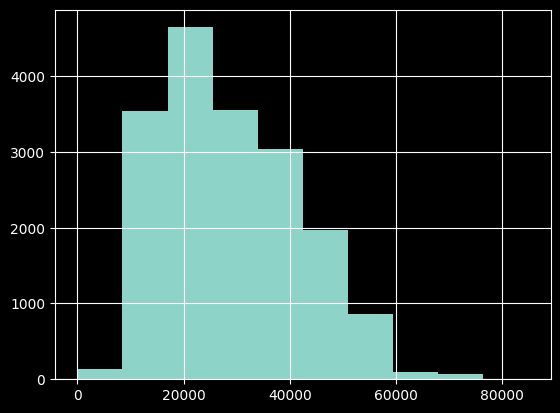

In [69]:
df.airports_nearest.hist()

Несмотря на существующие пропуски, этот параметр нам не сильно понадобится для дальнейшего исследования, поэтому лучше оставить пропуски как есть. Если потребуется их заполнить, это можно будет сделать позднее. Для удобства можно изменить размерность в этом столбце на километры вместо метров.

In [70]:
df.airports_nearest = round(df.airports_nearest / 1000,1)

Налачие и расстояние до парков,

In [71]:
df.parks_around3000.isna().sum()

5497

In [72]:
df.parks_nearest.isna().sum()

15500

In [73]:
df.ponds_around3000.isna().sum()

5497

In [74]:
df.ponds_nearest.isna().sum()

14502

In [75]:
df.query('parks_nearest.isna() and parks_around3000.notna() and parks_around3000!=0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [76]:
df.query('ponds_nearest.isna() and ponds_around3000.notna() and ponds_around3000!=0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


В этих параметров большое количество пропусков. Можно предположить, что когда расстояние до ближайшего парка или водоема больше 3км, многие продавцы не указывают это в своем объявлении.

При этом всегда, когда нет значения parks_around3000 или ponds_around3000, нет и точного значения до ближайшего парка или водоема.

In [77]:
df.ponds_nearest.describe()

count   8923.00
mean     520.38
std      278.22
min       13.00
25%      296.00
50%      505.00
75%      733.00
max     1344.00
Name: ponds_nearest, dtype: float64

In [78]:
df.parks_nearest.describe()

count   7925.00
mean     491.92
std      341.57
min        1.00
25%      288.00
50%      456.00
75%      613.00
max     3190.00
Name: parks_nearest, dtype: float64

 Описательные метрики подсказывают, что максимальное существующее расстояние до парков/водоемов меньше либо равно 3км. Это значит, мы можем заменить значение ближайшего парка и водоема на максимальное (или на 3км). Но пока лучше это не делать, тк это может исказить наши данные.

Во всяком случае можно безопасно заменить отсутвующие значения на 0 и перевести столбцы в формат int

In [79]:
df.ponds_around3000.fillna(0,inplace=True)
df.ponds_around3000 = df.ponds_around3000.astype('int')
df.parks_around3000.fillna(0,inplace=True)
df.parks_around3000 = df.ponds_around3000.astype('int')

/var/folders/7q/l3bhffcx34z1fmjrrhpm21zc0000gn/T/ipykernel_20159/2097569859.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.ponds_around3000.fillna(0,inplace=True)
/var/folders/7q/l3bhffcx34z1fmjrrhpm21zc0000gn/T/ipykernel_20159/2097569859.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

Далее рассмотрим параметр cityCenters_nearest. Сразу переименуем его в удобный формат

In [80]:
df = df.rename(columns={'cityCenters_nearest':'city_center_nearest'})

In [81]:
df.city_center_nearest.isna().sum()

5498

В этом параметре предложу воспользоваться следующей логикой:
Если в параметре остутствует значение, то можно заменить его медианным значением по locality_name; если в условном поселке в Ленобласти есть данные по расстоянию до центра Санкт-Петербурга, то оно не сильно будет отличаться. Проблемы могут возникнуть, если у нас много пропусков из непосредственно Санкт-Петербурга: в черте города разница расстоянии до центра может быть значительной. Посмтрим сколько этих значений:

In [82]:
df.query('locality_name == "Санкт-Петербург" and city_center_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
81,9,10949000.00,68.00,2018-12-27,1,NaN,10,32.97,6,True,...,16.85,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
593,20,4200000.00,38.30,2019-04-16,1,2.60,16,19.80,10,True,...,10.10,2,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
604,11,9899000.00,101.00,2018-12-12,3,3.00,5,62.00,3,True,...,15.00,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
742,7,37000000.00,161.00,2016-05-22,3,NaN,9,84.00,8,True,...,20.68,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,402.00
795,19,7100000.00,59.60,2019-02-13,2,3.40,5,36.60,2,True,...,12.50,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
1336,12,18500000.00,66.00,2017-06-08,1,3.00,7,25.00,7,True,...,35.00,1,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,130.00
1872,13,3100000.00,32.00,2019-03-15,1,NaN,4,19.00,2,False,...,5.00,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,3.00
1895,12,9500000.00,130.00,2019-03-27,5,NaN,5,90.00,2,True,...,15.00,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,15.00
2364,17,4300000.00,32.60,2019-04-28,1,NaN,25,14.30,17,True,...,8.10,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
2707,14,5650000.00,51.00,2019-02-26,2,3.20,9,31.00,5,True,...,10.00,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN


Всего 58 строк - можно смело заменять медианным значением и их тоже.

In [83]:
df.groupby('locality_name')['city_center_nearest'].agg('mean')
for i in df['locality_name'].unique():
    df.loc[(df['locality_name'] == i) & (df['city_center_nearest'].isna()),'city_center_nearest'] = df.groupby('locality_name')['city_center_nearest'].agg('median').loc[i]

In [84]:
df.city_center_nearest.isna().sum()

5431

Последнее - days_exposition - сколько дней было размещено объявление до снятия

In [85]:
df.days_exposition.isna().sum()

3143

<Axes: >

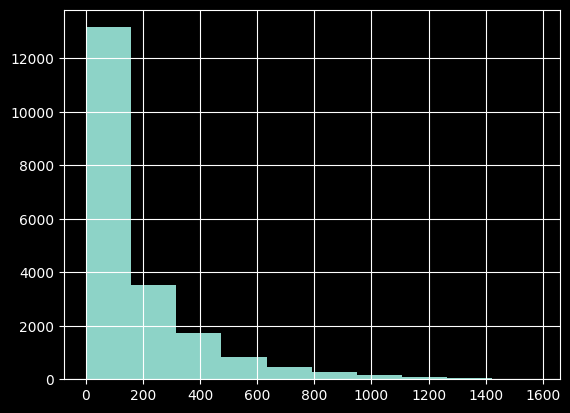

In [86]:
df.days_exposition.hist()

В этом параметре каких-то аномалий не наблюдается. Пропуски лучше оставить как есть

Финально проверим датасет на явные дубликаты:

In [87]:
df.duplicated().sum()

0

Явных дублей нет.

**Вывод по обработанным данным:**

Мы провели работу по очистке данных по продаже квартир в Санкт-Петербурге. Исправили некорректные значения, заполнили пропуски (где это было возможно), удалили явные дубликаты и некоторые выбросы, которые помешают нам в дальнейшем анализе. 

Качество исходных данных, несмотря на исправления, было высоким. Основные параметры, связанные с целевой переменной: цена, площадь квартиры, город, расстояние до центра - почти не требовали корректировок. Есть мелкие мелкие доработки:
- Можно добавить на сайт / в приложение флаг, требующий указания является ли квартира апартаментом или нет (тк при покупке или рассмотрения к покупке этот момент все равно уточняется покупателем). В этой графе больше всего пропусков, и восстановить их не представляется возможным

### Добавляем необходимые столбцы

Предобработка данных почти завершена. Осталось добавить необходимые для анализа столбцы:

 – цена одного квадратного метра;

 – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);

 – месяц публикации объявления;

 – год публикации объявления;

 – тип этажа квартиры (значения — «первый», «последний», «другой»);

 – расстояние до центра города в километрах.

In [88]:
df['sqm_price'] = round(df['last_price'] / df['total_area'],2)

In [89]:
df['exposition_weekday'] = df['first_day_exposition'].dt.weekday

In [90]:
df['exposition_month'] = df['first_day_exposition'].dt.month

In [91]:
df['exposition_year'] = df['first_day_exposition'].dt.year

In [92]:
df['city_center_distance_km'] = round(df.city_center_nearest / 1000,0)

Типизируем этажность квартиры с помощью функции:

In [93]:
def floor_typer(row):
  if row['floor'] == 1:
    return 'first'
  if row['floor'] == row['floors_total']:
    return 'last'
  else:
    return 'other'

In [94]:
df['floor_type'] = df[['floor','floors_total']].apply(floor_typer,axis=1)

In [95]:
df.floor_type.unique()

array(['other', 'first', 'last'], dtype=object)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23425 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23425 non-null  int64         
 1   last_price               23425 non-null  float64       
 2   total_area               23425 non-null  float64       
 3   first_day_exposition     23425 non-null  datetime64[ns]
 4   rooms                    23425 non-null  int64         
 5   ceiling_height           14384 non-null  float64       
 6   floors_total             23425 non-null  int64         
 7   living_area              23425 non-null  float64       
 8   floor                    23425 non-null  int64         
 9   is_apartment             23425 non-null  bool          
 10  studio                   23425 non-null  bool          
 11  open_plan                23425 non-null  bool          
 12  kitchen_area             23425 non-nu

In [97]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,exposition_weekday,exposition_month,exposition_year,city_center_distance_km,floor_type
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,True,...,482.00,2,755.00,NaN,120370.37,3,3,2019,16.00,other
1,7,3350000.00,40.40,2018-12-04,1,NaN,11,18.60,1,True,...,NaN,0,NaN,81.00,82920.79,1,12,2018,19.00,first
2,10,5196000.00,56.00,2015-08-20,2,NaN,5,34.30,4,True,...,90.00,2,574.00,558.00,92785.71,3,8,2015,14.00,other
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,True,...,112.00,1,48.00,121.00,100000.00,1,6,2018,8.00,other
5,10,2890000.00,30.40,2018-09-10,1,NaN,12,14.40,5,True,...,NaN,0,NaN,55.00,95065.79,0,9,2018,NaN,other


### Исследовательский анализ данных

**Общая площадь**

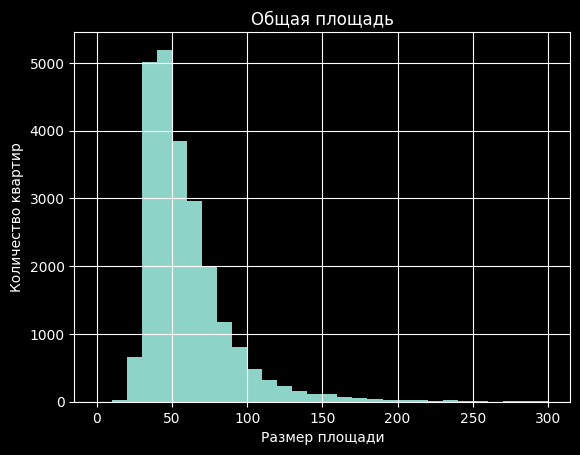

In [98]:
df.total_area.hist(bins=30,range=(0,300))
plt.title('Общая площадь')
plt.ylabel('Количество квартир')
plt.xlabel('Размер площади')
plt.show()

In [99]:
df.total_area.describe([0.05,0.25,0.5,0.75,0.95])

count   23425.00
mean       59.21
std        31.06
min        12.00
5%         31.00
25%        40.00
50%        52.00
75%        69.00
95%       112.68
max       517.00
Name: total_area, dtype: float64

Минимальный размер квартиры в представленных данных - 12 м2, максимальный - 517 м2. Медианное значение - 52 метра, а 95% квартир меньше 112 м2.

**Жилая площадь**

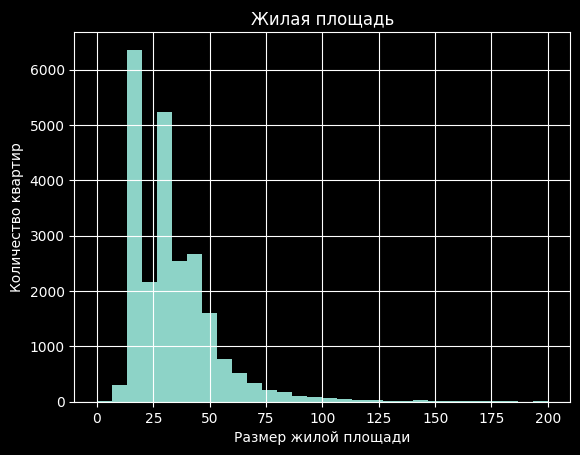

In [100]:
df.living_area.hist(bins=30,range=(0,200))
plt.title('Жилая площадь')
plt.ylabel('Количество квартир')
plt.xlabel('Размер жилой площади')
plt.show()

In [101]:
df.living_area.describe([0.05,0.25,0.5,0.75,0.95])

count   23425.00
mean       34.03
std        20.26
min         2.00
5%         15.10
25%        18.70
50%        30.00
75%        42.10
95%        68.00
max       332.00
Name: living_area, dtype: float64

Подробнее посмотрим на случаи, когда жилая площадь меньше 8 м2

In [102]:
df.query('living_area < 8')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,exposition_weekday,exposition_month,exposition_year,city_center_distance_km,floor_type
3242,7,4440000.00,41.00,2017-07-02,1,NaN,17,3.00,17,True,...,NaN,0,NaN,216.00,108292.68,6,7,2017,13.00,last
12040,5,1900000.00,15.00,2018-06-27,1,2.50,5,7.27,1,True,...,NaN,0,NaN,45.00,126666.67,2,6,2018,NaN,first
13915,20,6350000.00,52.00,2018-02-06,2,3.00,6,2.00,2,True,...,NaN,1,1012.00,91.00,122115.38,1,2,2018,7.00,other
16431,13,3799000.00,31.00,2018-04-12,1,2.60,5,6.00,1,True,...,430.00,0,NaN,168.00,122548.39,3,4,2018,5.00,first
16949,9,1550000.00,15.00,2018-08-21,1,2.70,9,7.27,1,True,...,NaN,1,1079.00,42.00,103333.33,1,8,2018,16.00,first
17582,11,2680000.00,22.00,2018-08-11,1,NaN,25,5.00,8,True,...,835.00,1,652.00,70.00,121818.18,5,8,2018,12.00,other
17961,3,1400000.00,13.00,2017-12-03,1,2.60,9,6.30,1,True,...,NaN,1,185.00,410.00,107692.31,6,12,2017,16.00,first
19251,19,4050000.00,33.00,2018-10-15,1,2.50,22,6.50,21,True,...,458.00,0,NaN,44.00,122727.27,0,10,2018,11.00,other
19546,3,1850000.00,13.00,2019-03-11,1,3.40,5,6.30,2,False,...,644.00,0,NaN,24.00,142307.69,0,3,2019,5.00,other
19558,2,1686000.00,13.20,2018-12-17,1,NaN,5,6.40,1,True,...,361.00,1,155.00,19.00,127727.27,0,12,2018,4.00,first


Внимание привлекают записи, где жилая площадь меньше 3 м2, а также 4хкомнатная квартира с жилой площадью 5 метров - это уж совсем странно. Удалим эти аномалии

In [103]:
df = df.drop(index=[3242,13915,21758,21943])

**Площадь кухни**

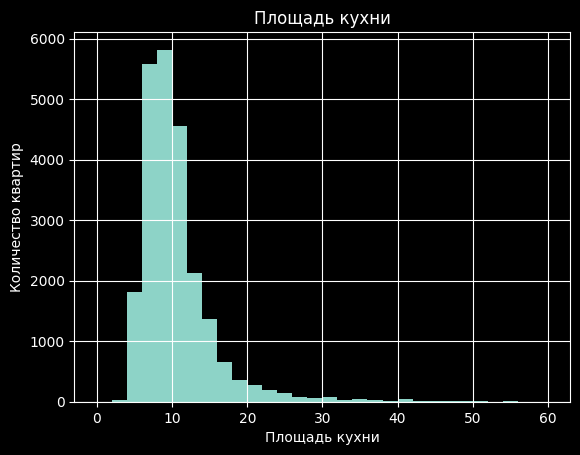

In [104]:
df.kitchen_area.hist(bins=30,range=(0,60))
plt.title('Площадь кухни')
plt.ylabel('Количество квартир')
plt.xlabel('Площадь кухни')
plt.show()

In [105]:
df.kitchen_area.describe([0.05,0.25,0.5,0.75,0.95])

count   23421.00
mean       10.32
std         5.32
min         1.30
5%          5.50
25%         7.00
50%         9.00
75%        11.64
95%        19.17
max       122.44
Name: kitchen_area, dtype: float64

Средняя площадь кухни - 9 м2, 90% всех кухонь - от 5.5 м2 до 19.3 м2. Также посмотрим на самые большие и самые маленькие кухни:

In [106]:
df.query('kitchen_area > 50')[['last_price', 'total_area', 'living_area', 'kitchen_area']]

,last_price,total_area,living_area,kitchen_area
2489,12500000.00,255.00,153.90,100.70
3561,12300000.00,115.00,45.00,60.00
4320,19700000.00,146.30,55.80,56.20
6021,16830000.00,117.40,33.40,51.00
6193,24300000.00,230.00,90.00,70.00
8261,36000000.00,123.20,31.20,58.40
8559,48000000.00,203.30,104.20,53.10
8709,24500000.00,105.00,31.10,51.00
9826,43185328.00,494.10,239.56,122.44
10789,38900000.00,151.60,63.31,56.00


In [107]:
df.query('kitchen_area < 4')[['last_price', 'total_area', 'living_area', 'kitchen_area']]

,last_price,total_area,living_area,kitchen_area
906,2600000.00,27.00,18.00,2.00
2165,3180000.00,25.00,17.00,3.00
3078,6000000.00,43.00,29.30,3.20
3195,2690000.00,25.60,16.20,3.80
6084,770000.00,18.00,13.00,3.00
6262,3100000.00,24.00,16.00,2.00
7047,2800000.00,21.00,14.90,3.80
7950,5967734.00,66.40,44.40,2.89
8712,14948000.00,42.70,27.50,3.70
8729,2200000.00,18.40,14.00,2.40


Каких-то очень больших нереалистичных значений не обнаружено

**Цена объекта**

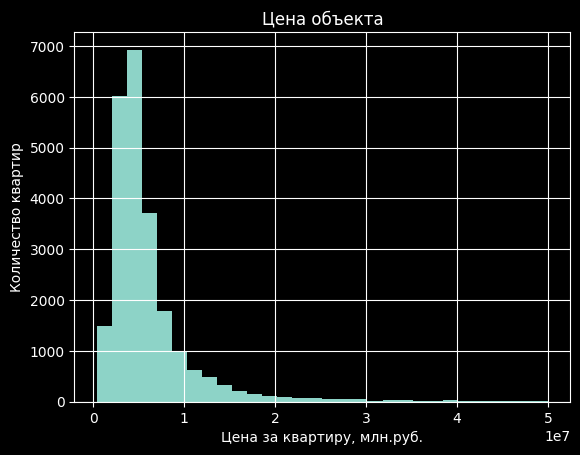

In [108]:
df.last_price.hist(bins=30)
plt.title('Цена объекта')
plt.ylabel('Количество квартир')
plt.xlabel('Цена за квартиру, млн.руб.')
plt.show()

In [109]:
df.last_price.describe([0.05,0.25,0.5,0.75,0.95]).apply(lambda x: format(x, 'f')) # отменяем Scientific Notation

count       23421.000000
mean      5995259.803382
std       4974913.647753
min        430000.000000
5%        1850000.000000
25%       3400000.000000
50%       4600000.000000
75%       6700000.000000
95%      14500000.000000
max      50000000.000000
Name: last_price, dtype: object

Данные по цене мы уже предобработали в предыдущем шаге. Можем подвести итоги: медианная цена квартиры в Санкт-Петербурге равна 4.6 млн, около 90% квартир расположены между 1.8 млн и 14.5 млн. Здесь также важно помнить, что мы "срезали" верхний слой (0.5%) дорогих квартир на этапе предобработки

**Количество комнат**

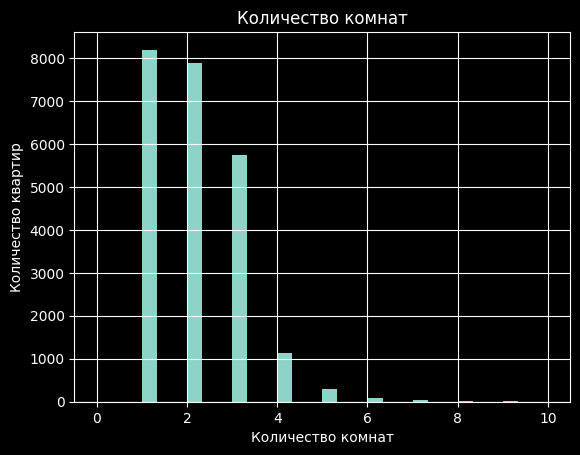

In [110]:
df.rooms.hist(bins=30,range=(0,10))
plt.title('Количество комнат')
plt.ylabel('Количество квартир')
plt.xlabel('Количество комнат')
plt.show()

In [111]:
df.rooms.describe()

count   23421.00
mean        2.06
std         1.04
min         1.00
25%         1.00
50%         2.00
75%         3.00
max        19.00
Name: rooms, dtype: float64

Медианное значение - 2 комнаты в квартире. Посмотрим на выбивающиеся значения сверху:

In [112]:
df.query('rooms>7')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,exposition_weekday,exposition_month,exposition_year,city_center_distance_km,floor_type
648,3,17500000.00,183.70,2018-07-01,11,3.40,7,138.80,7,True,...,NaN,0,NaN,NaN,95264.02,6,7,2018,3.00,last
813,7,16500000.00,229.00,2016-02-25,8,NaN,6,160.00,5,True,...,243.00,0,NaN,806.00,72052.40,3,2,2016,5.00,other
866,5,25000000.00,363.00,2017-12-23,14,3.16,5,222.00,4,True,...,NaN,2,435.00,418.00,68870.52,5,12,2017,8.00,other
4149,6,23000000.00,272.60,2018-01-11,10,3.14,7,145.90,7,True,...,191.00,1,531.00,NaN,84372.71,3,1,2018,12.00,last
4435,13,22190000.00,191.20,2017-12-05,8,2.90,6,115.80,1,True,...,587.00,2,155.00,115.00,116056.49,1,12,2017,1.00,first
8758,5,16100000.00,150.00,2018-07-10,8,2.92,5,107.00,1,True,...,473.00,0,NaN,NaN,107333.33,1,7,2018,5.00,first
8822,14,49968900.00,398.00,2017-07-12,9,3.00,2,160.10,1,False,...,471.00,2,440.00,471.00,125550.00,2,7,2017,17.00,first
8860,12,17000000.00,235.00,2018-07-14,9,3.00,6,149.30,3,True,...,346.00,0,NaN,90.00,72340.43,5,7,2018,5.00,other
9550,10,23500000.00,313.00,2017-02-13,9,3.20,6,179.20,5,True,...,146.00,0,NaN,NaN,75079.87,0,2,2017,10.00,other
9688,8,33000000.00,194.10,2017-02-07,11,3.43,5,129.00,2,True,...,686.00,2,66.00,813.00,170015.46,1,2,2017,1.00,other


**Высота потолков**

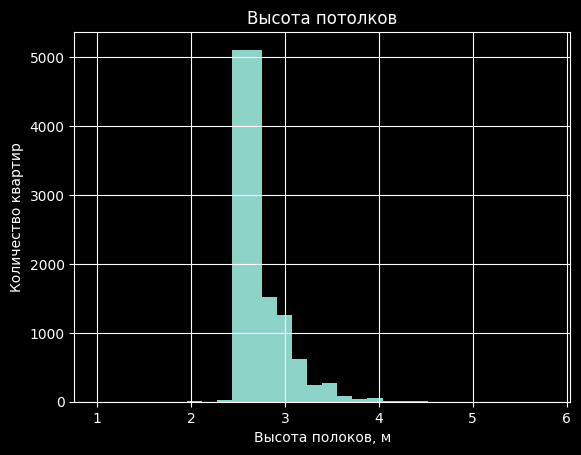

In [113]:
df.ceiling_height.hist(bins=30)
plt.title('Высота потолков')
plt.ylabel('Количество квартир')
plt.xlabel('Высота полоков, м')
plt.show()

In [114]:
df.query('ceiling_height < 1.5')
df = df.drop(df.query('ceiling_height < 1.5').index)

In [115]:
df.ceiling_height.describe([0.05,0.25,0.5,0.75,0.95])

count   14380.00
mean        2.72
std         0.27
min         1.75
5%          2.50
25%         2.51
50%         2.65
75%         2.80
95%         3.25
max         5.80
Name: ceiling_height, dtype: float64

Удалим совсем нереалистичные размеры потолков - те, что ниже 1.5м . Здесь же важно указать, что медианная высота равна 2.65м, минимальная - 1.75м, а 95% потолков ниже 3,25 м.

**Тип этажа квартиры**

<Axes: >

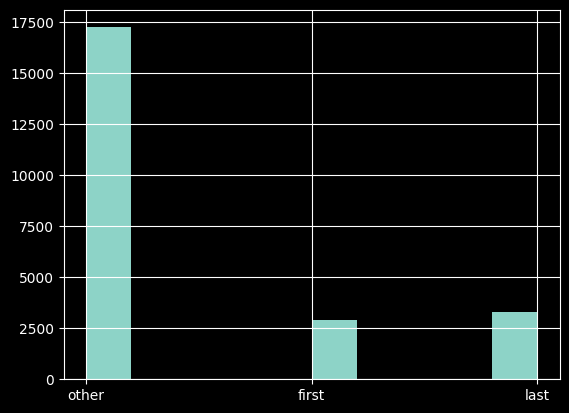

In [116]:
df.floor_type.hist()

На этом этапе график не очень показательный, скорее очевидный. Далее рассмотрим тип этажа во взаимосвязи с ценой квартиры

**Общее количество этажей в доме**

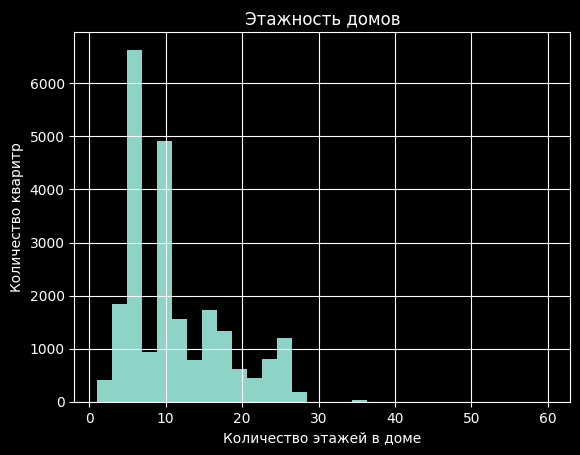

In [117]:
df.floors_total.hist(bins=30)
plt.title('Этажность домов')
plt.ylabel('Количество кваритр')
plt.xlabel('Количество этажей в доме')
plt.show()

In [118]:
df.floors_total.describe([0.05,0.25,0.5,0.75,0.95])

count   23419.00
mean       10.69
std         6.60
min         1.00
5%          4.00
25%         5.00
50%         9.00
75%        16.00
95%        25.00
max        60.00
Name: floors_total, dtype: float64

Здесь интересны два пика - это классические российские пятиэтажки и деваятиэтажки. В остальном график логичный, есть как одноэтажные дома, так и высотки.

**Расстояние до центра города**

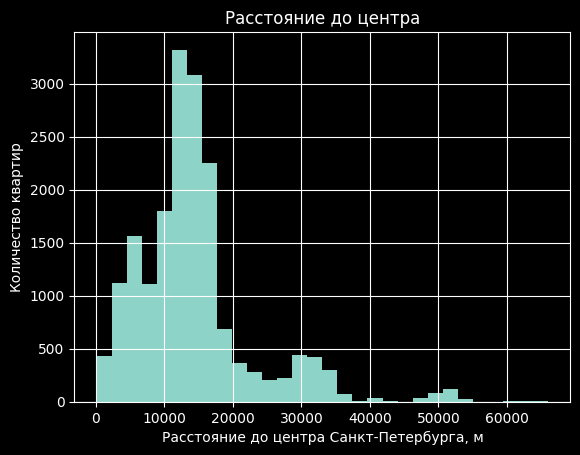

In [119]:
df.city_center_nearest.hist(bins=30)
plt.title('Расстояние до центра')
plt.ylabel('Количество квартир')
plt.xlabel('Расстояние до центра Санкт-Петербурга, м')
plt.show()

In [120]:
df.city_center_nearest.describe([0.05,0.25,0.5,0.75,0.95])

count   17990.00
mean    14265.72
std      8602.09
min       181.00
5%       3619.00
25%      9413.50
50%     13138.00
75%     16298.00
95%     31783.45
max     65968.00
Name: city_center_nearest, dtype: float64

Медианное значение до центра - 13км. 90% объектов недвижимости расположены между 3.6 и 31 км - это также можно объяснить там, что кроме Санкт-Петербурга в выборке есть объекты из ближайших поселков. Интересно, что около 30 км и 50 км есть небольшие "бугорки" - скорее всего, там расположены крупные города Ленобласти

In [121]:
df.query('25 < city_center_distance_km < 35')['locality_name'].value_counts()

locality_name
Пушкин                     331
Колпино                    329
поселок Шушары             186
Красное Село               167
Петергоф                   142
Сестрорецк                  78
поселок Металлострой        66
Санкт-Петербург             58
Павловск                    27
поселок Понтонный           20
поселок Песочный             4
поселок Лисий Нос            3
поселок Александровская      2
поселок Усть-Ижора           2
поселок Петро-Славянка       1
поселок Левашово             1
Name: count, dtype: int64

In [122]:
df.query('45 < city_center_distance_km < 55')['locality_name'].value_counts()

locality_name
Ломоносов      122
Кронштадт       96
Петергоф        24
Зеленогорск     17
Name: count, dtype: int64

Действительно, это города Пушнин, Колпино, п.Шушары и город Ломоносов.

**Расстояние до ближайшего парка**

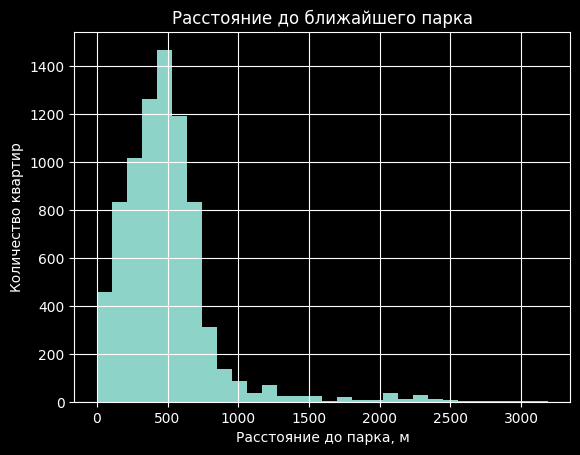

In [123]:
df.parks_nearest.hist(bins=30)
plt.title('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир')
plt.xlabel('Расстояние до парка, м')
plt.show()

В Санкт-Петербурге часто парки чаще всего встречаются в пределах 500 м от дома.

**Насколько быстро продавались квартиры?**

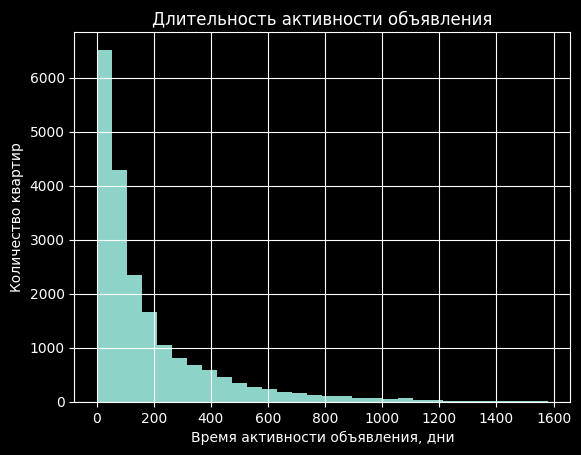

In [124]:
df.days_exposition.hist(bins=30)
plt.title('Длительность активности объявления')
plt.ylabel('Количество квартир')
plt.xlabel('Время активности объявления, дни')
plt.show()

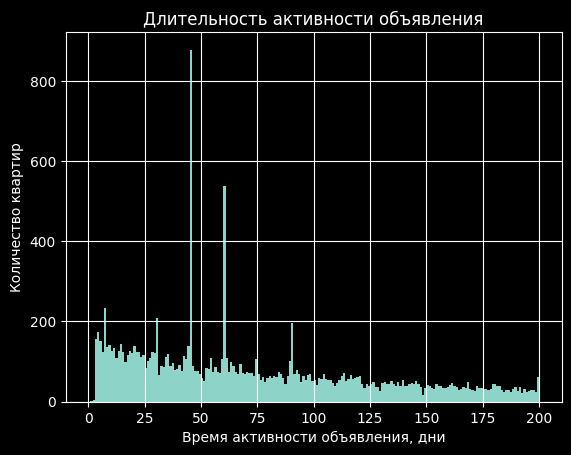

In [125]:
df.days_exposition.hist(bins=200,range=(0,200))
plt.title('Длительность активности объявления')
plt.ylabel('Количество квартир')
plt.xlabel('Время активности объявления, дни')
plt.show()

In [126]:
df.days_exposition.value_counts()

days_exposition
45.00      878
60.00      538
7.00       234
30.00      208
90.00      196
          ... 
793.00       1
1434.00      1
1231.00      1
739.00       1
971.00       1
Name: count, Length: 1137, dtype: int64

При более детальном рассмотрении отрезка от 0 до 200 дней можно заметить три интересных пика графика - на 45, 60 и 90 днях. Возможно, это как-то связано с системой Яндекс.Недвижимости - после этих отсечек без активности система считает объявление неактивным. Это можно уточнить с командой продукта

In [127]:
df.days_exposition.describe([0.1,0.25,0.5,0.75,0.9])

count   20276.00
mean      180.00
std       219.20
min         1.00
10%        17.00
25%        45.00
50%        95.00
75%       230.00
90%       456.00
max      1580.00
Name: days_exposition, dtype: float64

Что касается времени, которое объявление висело на сайте, то медианное значение времени продажи квартиры - 95 дней (то есть 3 месяца). Среднее время при этом - полгода, то есть у нас наблюдается "длинный хвост" из объявлений, которые долго не продавались.

Быстрыми продажами можно назвать продажи в течение 17 дней - таких продаж около 10%. Но часть покупателей продавали квартиры больше полутора лет - эти продажи будем считать долгими

**Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

Для ответа на этот вопрос рассмотрим некоторые параметры и посмотрим коэффициент корреляции между ними и целевой переменной, а также построим диаграммы рассеяния.

**Общая площадь**

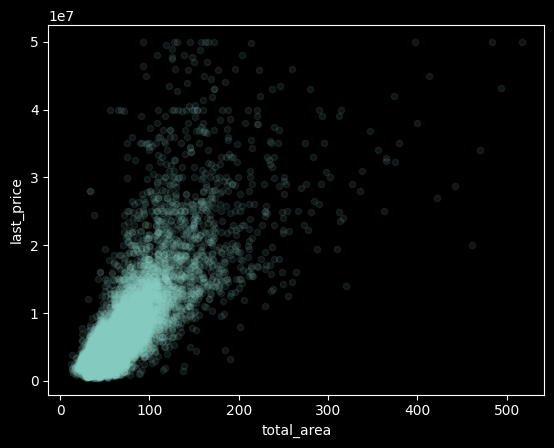

In [128]:
df.plot(kind='scatter',x='total_area',y='last_price',alpha=0.1);

In [129]:
df.last_price.corr(df.total_area)

0.7811649678085251

Коэффициент корреляции Пирсона показывает очень высокую зависимость - почти 0.8. То есть чем больше площадь квартиры, тем больше цена, что логично. Особенно показательна зависимость до 20 млн рублей - дальше увеличение цены более хаотично и зависит от иных факторов.

**Жилая площадь**

<Axes: xlabel='living_area', ylabel='last_price'>

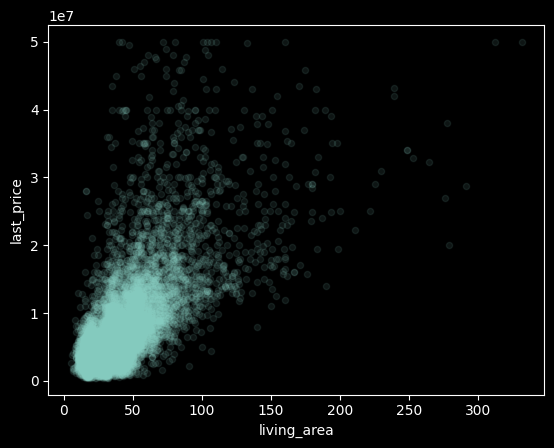

In [130]:
df.plot(kind='scatter',x='living_area',y='last_price',alpha=0.1)

In [131]:
df.last_price.corr(df.living_area)

0.6937333029008245

Ситуация похожа на распределение общей площади. Хотя коэффициент Пирсона меньше, он все равно показывает серьезную зависимость между показателями.

<Axes: xlabel='kitchen_area', ylabel='last_price'>

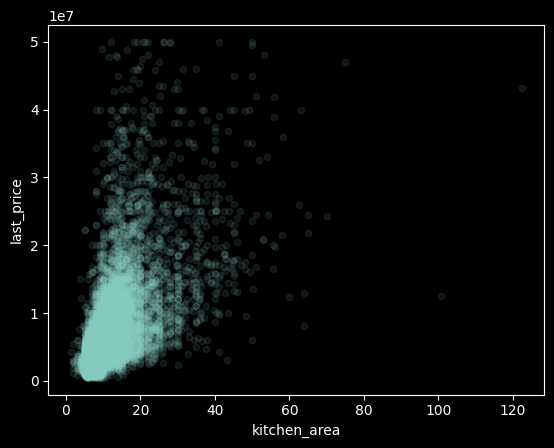

In [132]:
df.plot(kind='scatter',x='kitchen_area',y='last_price',alpha=0.1)

In [133]:
df.last_price.corr(df.kitchen_area)

0.6083034220341769

Аналогичная ситуация - коэффициент корреляции еще меньше, но корреляция прослеживается. Как известно, корреляция не означает зависимости; мы можем предположить, что размер жилой площади и размер кухни напрямую коррелируют с общей площадью квартиры, а она уже в свою очередь влияет на цену квартиры

**Количество комнат**

Для ответа на вопрос по количеству комнат, диаграмма рассеяния будет не так показательна. Лучше подойдет столбчатая диаграмма

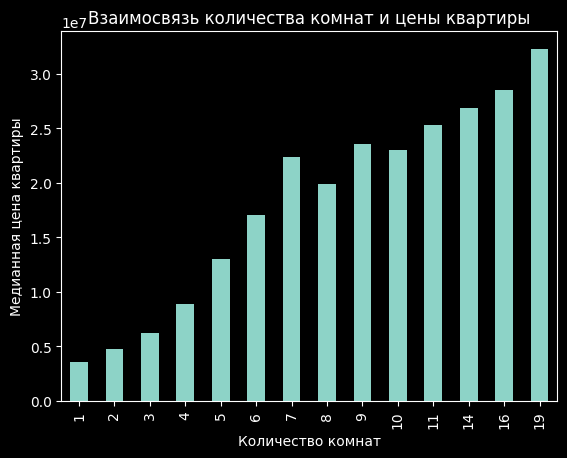

In [134]:
df.groupby('rooms')['last_price'].agg('median').plot(kind='bar')
plt.title('Взаимосвязь количества комнат и цены квартиры')
plt.ylabel('Медианная цена квартиры')
plt.xlabel('Количество комнат')
plt.show()

Как видно, чем больше комнат - тем выше медианная цена квартиры. Это логично, и опять же прослеживается связь с общей площадью

**Тип этажа (первый, последний, другой)**

Аналогичным образом посмотрим взаимосвязь между типом этажа квартиры и ценовыми сегментами:

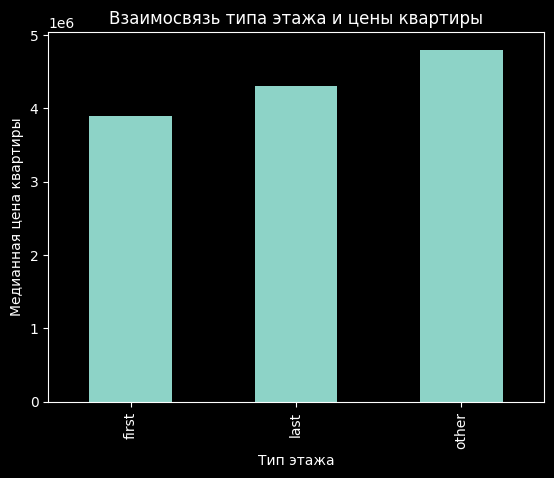

In [135]:
df.groupby('floor_type')['last_price'].agg('median').plot(kind='bar')
plt.title('Взаимосвязь типа этажа и цены квартиры')
plt.ylabel('Медианная цена квартиры')
plt.xlabel('Тип этажа')
plt.show()

Здесь мы уже видим, как выстраивается цена квартиры в зависимости от типа этажа. Самые дешевые квартиры - на первом этаже, потом идут квартиры на последнем этаже, и потом - на всех остальных.

Низкую стоимость квартир на первом этаже можно попробовать объяснить тем, что первый этаж часто связан с высоким шумом с улицы и "непрошенных взглядов", а также более легкой доступности для воров (по крайней мере, бытует такое мнение). Последний этаж часто не предпочитают также из-за более легкой доступности для воров, а также возможными проблемами с водоснабжением в старых домах.

**Год, месяц, день недели выставления объявления**

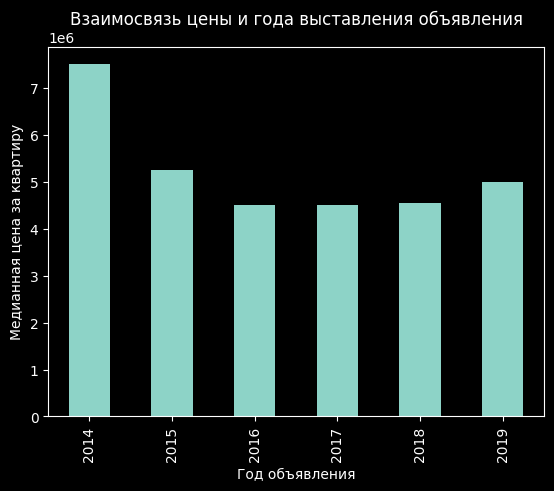

In [136]:
df.groupby('exposition_year')['last_price'].agg('median').plot(kind='bar')
plt.title('Взаимосвязь цены и года выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('Год объявления')
plt.show()

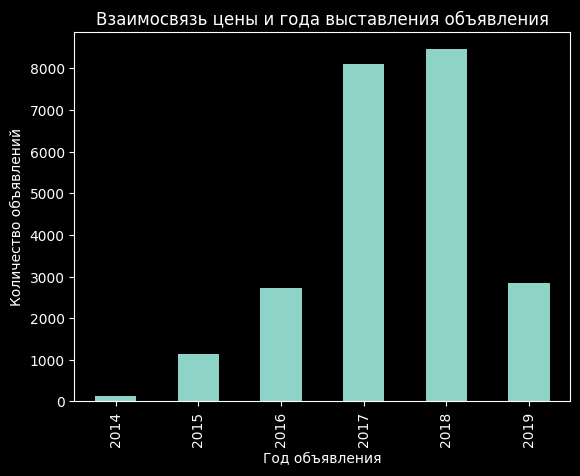

In [137]:
df.groupby('exposition_year')['last_price'].agg('count').plot(kind='bar')
plt.title('Взаимосвязь цены и года выставления объявления')
plt.ylabel('Количество объявлений')
plt.xlabel('Год объявления')
plt.show()

In [138]:
df.groupby('exposition_year')['last_price'].agg('count')

exposition_year
2014     133
2015    1144
2016    2724
2017    8110
2018    8455
2019    2853
Name: last_price, dtype: int64

Сначала рассмотри ситуацию с годом. Медианная цена за квартиры снижалась до 2018 года, и немного отрасла к 2019. Однако количество объявлений, наоборот, было наиболее высоким в 2017 и 2018 год.

Также взглянем на абсолютные цифры по количеству объявлений - скорее всего, в тренд на снижение медианной цены и правда был, но не настолько значительный - количество выставленных объявлений в 2014 ограничен выборкой.

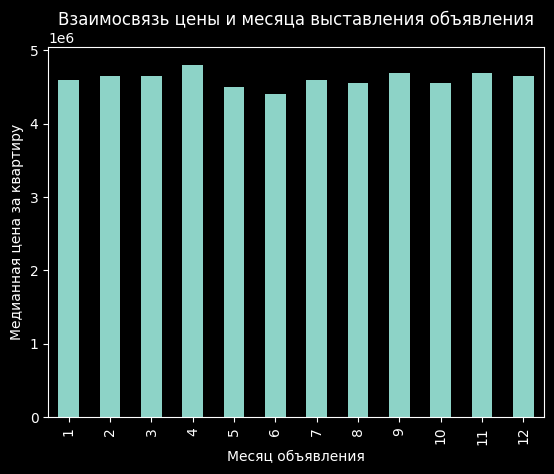

In [139]:
df.groupby('exposition_month')['last_price'].agg('median').plot(kind='bar')
plt.title('Взаимосвязь цены и месяца выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('Месяц объявления')
plt.show()

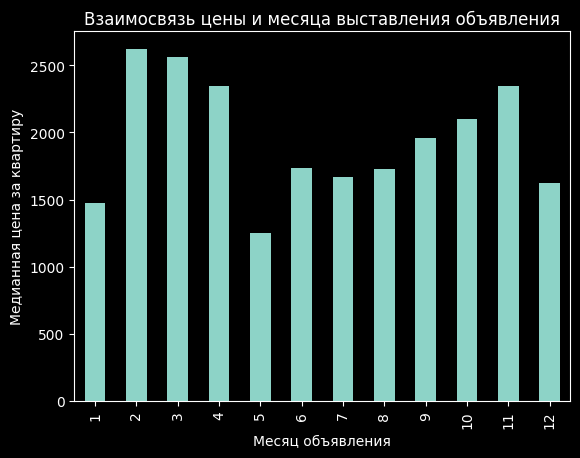

In [140]:
df.groupby('exposition_month')['last_price'].agg('count').plot(kind='bar')
plt.title('Взаимосвязь цены и месяца выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('Месяц объявления')
plt.show()

Точно можно сказать, что месяц выставления объявления не влияет на цену квартиры. Но мы можем изучить сезонность рынка недвижимости в Санкт-Петербурге
На графике месяцев можно было бы проследить сезонность выставления объявлений, если бы выборка была равномерно разбита по годам. Мы можем ограничить выборку полными годами и построить аналогичный график:

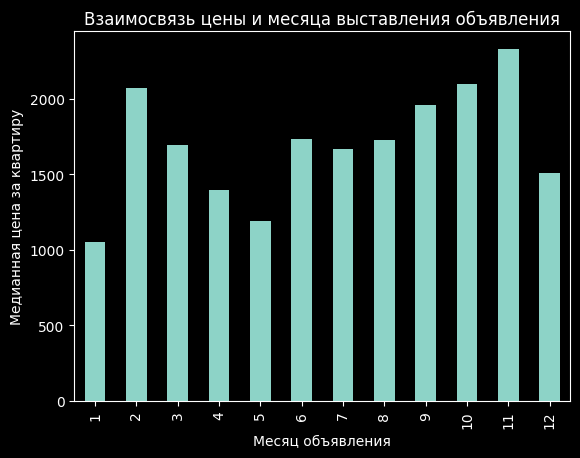

In [141]:
df.query('exposition_year in [2015,2016,2017,2018]').groupby('exposition_month')['last_price'].agg('count').plot(kind='bar')
plt.title('Взаимосвязь цены и месяца выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('Месяц объявления')
plt.show()

Здесь можем заметить, что самыми холодными с точки зрения продаж являются январь, май и декабрь, а самыми горячими - февраль, ноябрь и октябрь.

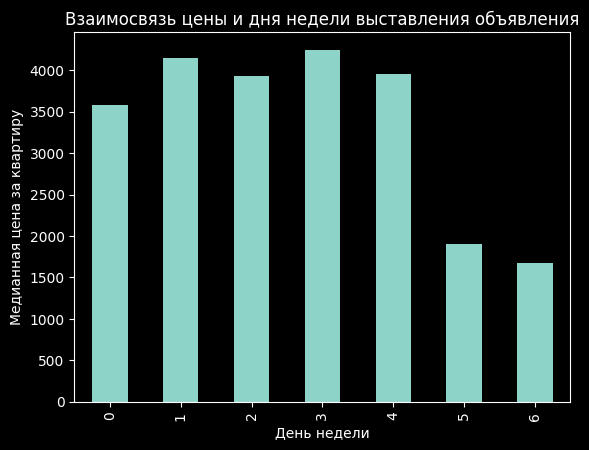

In [142]:
df.groupby('exposition_weekday')['last_price'].agg('count').plot(kind='bar')
plt.title('Взаимосвязь цены и дня недели выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('День недели')
plt.show()

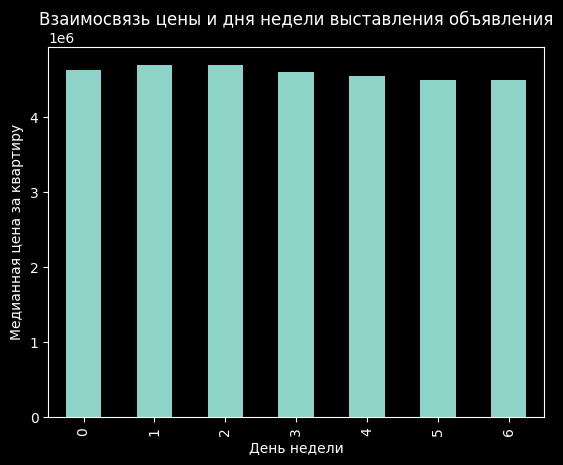

In [143]:
df.groupby('exposition_weekday')['last_price'].agg('median').plot(kind='bar')
plt.title('Взаимосвязь цены и дня недели выставления объявления')
plt.ylabel('Медианная цена за квартиру')
plt.xlabel('День недели')
plt.show()

Что касается медианной цены - она не отличается от времени выставления. Также заметим, что люди чаще выставляют объявления по будням.

**Какова средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений?**

Составим сводную таблицу по стоимости квадратного метра и отсортируем ее по количеству:

In [144]:
top_locality = df.groupby('locality_name')['sqm_price'].agg(['count','mean']).sort_values('count',ascending=False).head(10)
top_locality.sort_values('mean',ascending=False)

,count,mean
locality_name,,
Санкт-Петербург,15509,112226.57
Пушкин,369,103125.82
деревня Кудрово,299,92473.55
поселок Парголово,327,90175.91
поселок Мурино,551,85601.12
поселок Шушары,439,78551.34
Колпино,338,75424.58
Гатчина,307,68746.15
Всеволожск,398,68654.47


Самые дорогие квартиры по среднему квадратному метру из представленных в данных - квартиры в самом Санкт-Петербурге. Самый дешевый средний квадратный метр можно найти в Выборге. Скорее всего, важным параметром влияющий на стоимость квадратного метра является удаленность от Санкт-Петербурга, а внутри Петербурга - удаленность от центра (см. далее).

Можно заметить также, что стоимость кв.м. в Санкт-Петербурга в два раза выше средней стоимости в Выборге

**Как изменялась цена квадратного метра?**

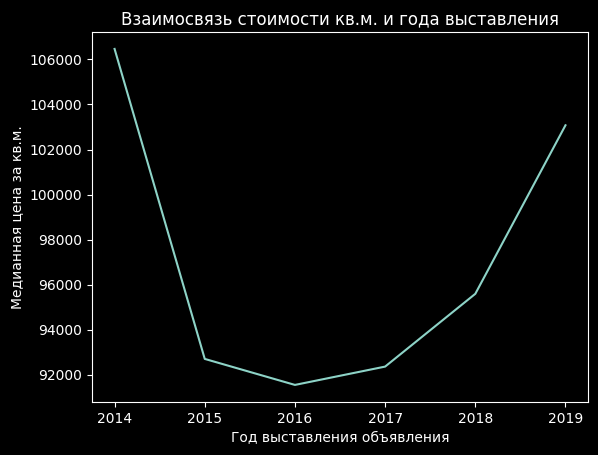

In [145]:
df.groupby('exposition_year')['sqm_price'].agg('median').plot()
plt.title('Взаимосвязь стоимости кв.м. и года выставления')
plt.ylabel('Медианная цена за кв.м.')
plt.xlabel('Год выставления объявления')
plt.show()

По графику видно, что с 2014 года стоимость квадратного метра в Санкт-Петербурге и окрестностях падала, достигнув минимума в 2016, но после снова поднялась к 2019 году. Конкретных причин не назовем, т.к. их может быть много разнонаправленных, и к конкретному исследованию они не относятся

**Как изменялась площади продаваемых квартир?**

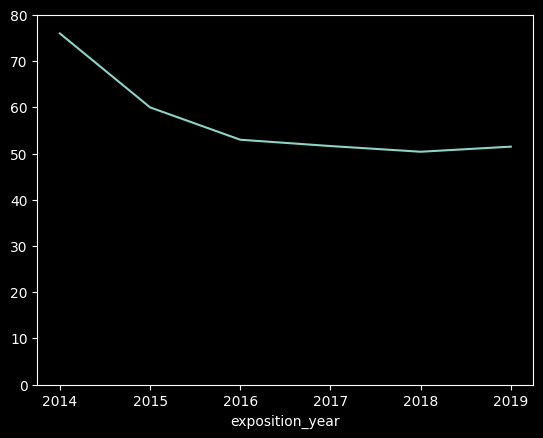

In [146]:
df.groupby('exposition_year')['total_area'].agg('median').plot(ylim=(0,80));

График показывает, что начиная с 2014 года площадь выставляемых квартир снижались. Вероятно, это повлияло на изменение медианной стоимости квартир год к году.

**Как зависит цена квартиры в Санкт-Петербурге от удаленности от центра?**

Чтобы ответить на этот вопрос, мы создадим отдельный датафрейм с квартирами из Санкт-Петербурга. В этом датафрейме мы разделим квартиры в зависимости от их расстоянию от центра, а потом посчитаем среднюю ценую квартиры на каждом из слоев

In [147]:
df_spb = df.query('locality_name == "Санкт-Петербург"')
bins = range(math.floor(min(df_spb.city_center_distance_km)),math.ceil(max(df_spb.city_center_distance_km)))
df_spb['km_cut'] = pd.cut(df.city_center_distance_km,bins=bins, right = False)
df_spb_grouped = df_spb.groupby('km_cut')['last_price'].agg(['mean','count'])
df_spb_grouped

/var/folders/7q/l3bhffcx34z1fmjrrhpm21zc0000gn/T/ipykernel_20159/2823195113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spb['km_cut'] = pd.cut(df.city_center_distance_km,bins=bins, right = False)
/var/folders/7q/l3bhffcx34z1fmjrrhpm21zc0000gn/T/ipykernel_20159/2823195113.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_spb_grouped = df_spb.groupby('km_cut')['last_price'].agg(['mean','count'])


,mean,count
km_cut,,
"[0, 1)",20577462.09,23
"[1, 2)",13095292.13,178
"[2, 3)",12358659.79,291
"[3, 4)",10330852.76,344
"[4, 5)",11132893.10,679
"[5, 6)",11726518.58,889
"[6, 7)",11979328.18,592
"[7, 8)",11477238.31,396
"[8, 9)",9148514.65,591


Построим график

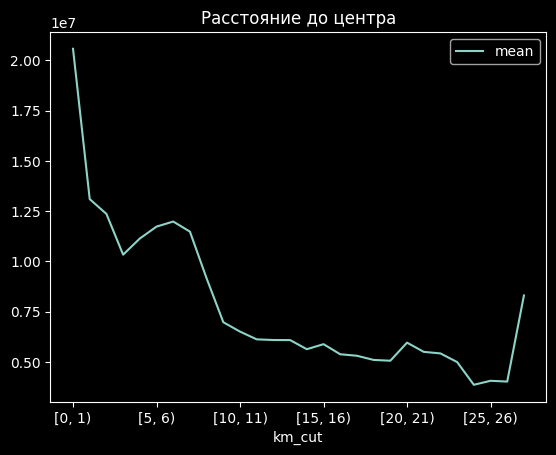

In [148]:
df_spb_grouped.plot(kind='line',y='mean', title = 'Расстояние до центра');

Можно сделать однозначный вывод, что чем ближе к центру Санкт-Петербурга расположена квартира, тем выше ее стоимость. На графике есть небольшой всплеск от 4 до 7 км от центра, в котором прямая зависимосить не прослеживается - возможно, там расположен более премиальный район, где квартиры стоят дороже. Также можно заметить, что начиная с 10 км от центра падение стоимости квартир замедляемся, и эластичность удаления от центра снижается (то есть, не так важно, 10 км от центра или 15, но важно 1 км от центра или 3). Также есть незначительный выброс справа на графике, но здесь выводы делать нельзя изза небольшой выборки.

### Общий вывод

Мы провели анализ по данным Яндекс.Недвижимости об стоимости продажи квартир в Санкт-Петербурге и ближайших поселках Ленобласти. В ходе исследования мы:
- предобработали данные: обработали выбросы и аномалии
- удалили дубликаты и нереалистичные показатели
- исправили формат столбцов, где это возможно

А также мы нашли некоторые закономерности в ценах квартир в Санкт-Петербурге и ближайших окрестностях:

1. Наиболее важные параметры, влияющие на цену квартиры в Санкт-Петербурге - это удаленность от центра и общая площадь квартиры. Также влияние оказывают этаж, на котором располагается квартира, жилая площадь и площадь кухни, количество комнат - но зависимость меньше, чем у первых двух показателей.
2. Самые дорогие квартиры по среднему квадратному метру из представленных в данных - квартиры в самом Санкт-Петербурге. Самый дешевый средний квадратный метр можно найти в Выборге. Стоимость кв.м. в Санкт-Петербурга в два раза выше средней стоимости в Выборге и составляет 112 000 за кв. м.
3. Можно заключить, что чем ближе к центру Санкт-Петербурга находится квартира, тем выше ее цена. Однако на графике мы видим небольшой всплеск в пределах от 4 до 7 км от центра, где прямая зависимость не так очевидна. Возможно, это связано с наличием более дорогих районов в этом диапазоне. Также стоит отметить, что после 10 км от центра падение цен на квартиры замедляется, что означает, что каждый километр от центра становится менее важным для определения цены.
4. В среднем квартиры продаются за 95 дней, что составляет около 3 месяцев. Однако среднее время продажи составляет полгода, что означает, что есть некоторые квартиры, которые остаются на продаже значительно дольше. Это указывает на то, что есть объявления, которые находятся на рынке продажи в течение длительного времени, образуя так называемый "длинный хвост".
5. Цена квартиры зависит от этажа, на котором она располагается. Самые дешевые квартиры расположены на первом этаже, наиболее дорогие - на промежуточных этажах (всех кроме первого и последнего)
6. На рынке продажи жилья наблюдается сезонность. Самыми "холодными" являются январь, май и декабрь, самыми "горячими" месяцами - февраль, октябрь и ноябрь. Также можно заметить, что продавцы чаще выставляют объявления в будни дни.
7. Цена квартир снижалась, начиная с 2014 года до 2018 года. Это связано с тем, что с 2014 года аналогично снижалась и площадь выставляемых квартир. Что касается количества выставляемых объявлений, оно наоброт росло, досигнув пика в 2018 году.
8. В дополнение к предыдущему пункту - мы рассмотрели цену за квадратный метр, как показатель, более устойчивый к изменению площади квартиры. Цена за кв. м. также снижался до 2016 года, но потом восстановился до почти прежних значений к 2019 году.